# Processing REDUCEDHEATARB data for heat distribution system model check

In [75]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
# Files needed as input
# rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_5_min.parquet'
rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_1_min.parquet'
home_data_file_path = "home_data.parquet"
boiler_returntemp_load_efficiency_file_path = "boiler_returntemp_load_efficiency.parquet"
boiler_returntemp_efficiency_file_path = "boiler_returntemp_efficiency.parquet"

# Files written as output
rhc_heat_dist_preprocessed_poperties_file='rhc_heat_dist_preprocessed_properties.parquet'

%load_ext autoreload

import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib widget

import sys
sys.path.append('../analysis')
sys.path.append('../data')
sys.path.append('../view/')
from nfh_utils import *
from plotter import Plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading preprocessed interpolated properties from a parquet file

In [ ]:
%%time


# Attempt to read the Parquet file
try:
    df_prep = pd.read_parquet(
        rhc_preprocessed_poperties_file, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

#sorting the DataFrame index is needed to get good performance on certain filters
#this guarding code to check whether DataFrames are properly sorted
if not df_prep.index.is_monotonic_increasing:
    print('df needed index sorting')
    df_prep = df_prep.sort_index()  

In [ ]:
print(f"df_prep.count().sum(): {df_prep.count().sum():_}")

In [50]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9582620 entries, (401632, Timestamp('2023-04-01 00:00:00+0200', tz='Europe/Amsterdam')) to (495906, Timestamp('2024-04-04 01:00:00+0200', tz='Europe/Amsterdam'))
Data columns (total 78 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   batch_import_KNMI_ghi__W_m_2                             Float32
 1   batch_import_KNMI_temp_out__degC                         Float32
 2   batch_import_remeha_temp_out__degC                       Float32
 3   batch_import_KNMI_wind__m_s_1                            Float32
 4   batch_import_enelogic_e_ret_monthly_hi_cum__kWh          Float64
 5   batch_import_enelogic_e_ret_monthly_lo_cum__kWh          Float64
 6   batch_import_enelogic_e_use_monthly_hi_cum__kWh          Float64
 7   batch_import_enelogic_e_use_monthly_lo_cum__kWh          Float64
 8   batch_import_enelogic_g_use_monthly_cum__m3       

In [ ]:
print("[\n'","', \n'".join(sorted(df_prep.columns)),"'\n]")

## Filtering values immediately relevant for heat distribution system modelling

In [ ]:
heat_distribution_props = [
    'batch_import_KNMI_ghi__W_m_2', 
    'batch_import_KNMI_temp_out__degC', 
    'batch_import_KNMI_wind__m_s_1', 
    'device_p1-reader_g_use_hhv__W', 
    'batch_import_remeha_boiler_status_burning_ch__bool',
    'batch_import_remeha_gas_valve_closed__bool', 
    'batch_import_remeha_gas_valve_open__bool', 
    'batch_import_remeha_fan_rotations__min_1', 
    'batch_import_remeha_ch_set_fan_rotations_min__min_1', 
    'batch_import_remeha_ch_set_fan_rotations_max__min_1',       
    'batch_import_remeha_g_use_ch_lhv__W',
    'batch_import_remeha_temp_set__degC', 
    'batch_import_remeha_temp_in__degC', 
    'device_living_room_calibrated_temp_in__degC', 
    'batch_import_remeha_temp_sup__degC', 
    'batch_import_remeha_temp_ch_sup_max__degC', 
    'batch_import_remeha_temp_ret__degC' 
]

In [ ]:
df_heat_dist = df_prep[heat_distribution_props].copy()

In [ ]:
print(f"df_heat_dist.count().sum(): {df_heat_dist.count().sum():_}")

In [ ]:
df_heat_dist.info()

## Calculating additional values relevant for heat distribution system modelling

In [ ]:
%%time

# Filter out rows where either of the columns has NaN
valid_rows = df_heat_dist[['batch_import_remeha_temp_sup__degC', 'batch_import_remeha_temp_ret__degC']].notna().all(axis=1)

# Calculate the mean only for valid rows
df_heat_dist.loc[valid_rows, 'calculated_temp_rad__degC'] = df_heat_dist.loc[valid_rows, ['batch_import_remeha_temp_sup__degC', 'batch_import_remeha_temp_ret__degC']].mean(axis=1)

## Reading boiler data

In [ ]:
%%time
# Attempt to read the Parquet file
try:
    df_homes = pd.read_parquet(
        home_data_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
df_homes.info()

In [ ]:
%%time
# Attempt to read the Parquet file
try:
    df_boiler_efficiency = pd.read_parquet(
        # boiler_returntemp_efficiency_file_path, 
        boiler_returntemp_load_efficiency_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
df_boiler_efficiency

## Calculating heat production

In [ ]:
# # Calculate Q_gain_ch__W based on national average efficiency
# df_heat_dist['calculated_Q_gain_ch__W'] = df_heat_dist['batch_import_remeha_g_use_ch_lhv__W'] *  g_groningen_hhv___MJ_m_3 /  g_groningen_lhv___MJ_m_3 * eta_ch_nl_avg_hhv__J0

In [ ]:
g_groningen_hhv___MJ_m_3

In [ ]:
g_groningen_lhv___MJ_m_3

In [43]:
g_not_ch_nl_avg_hhv__W

377.80534641417603

In [ ]:
%%time
# Round return temperatures to whole degrees
df_heat_dist['rounded_temp_ret__degC'] = df_heat_dist['batch_import_remeha_temp_ret__degC'].round()

In [ ]:
df_heat_dist.info()

In [ ]:
df_heat_dist.index.dtypes

In [ ]:
df_heat_dist.count()

In [ ]:
df_heat_dist.groupby(level='id').count().T

In [ ]:
pd.concat([df_heat_dist.dropna().groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_min__min_1'].unique(),
           df_heat_dist.dropna().groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_max__min_1'].unique()],
          axis=1).sort_values(by='batch_import_remeha_ch_set_fan_rotations_max__min_1', ascending=True)

In [ ]:
df_heat_dist.groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_max__min_1'].unique()

In [ ]:
# Merge df_heat_dist with df_homes to get the brand_model for each id
df_heat_dist = df_heat_dist.reset_index().merge(df_homes, on='id').set_index(['id', 'timestamp'])

In [ ]:
df_heat_dist.info()

In [ ]:
df_heat_dist.count()

In [ ]:
df_heat_dist = df_heat_dist[['batch_import_KNMI_ghi__W_m_2',
                             'batch_import_KNMI_temp_out__degC',
                             'batch_import_KNMI_wind__m_s_1',
                             'device_p1-reader_g_use_hhv__W',
                             'batch_import_remeha_boiler_status_burning_ch__bool',
                             'batch_import_remeha_gas_valve_closed__bool',
                             'batch_import_remeha_gas_valve_open__bool',
                             'batch_import_remeha_fan_rotations__min_1', 
                             'batch_import_remeha_ch_set_fan_rotations_min__min_1', 
                             'batch_import_remeha_ch_set_fan_rotations_max__min_1', 
                             'boiler_default_min_fan_rotations__min_1', 
                             'boiler_default_max_ch_fan_rotations__min_1', 
                             'batch_import_remeha_g_use_ch_lhv__W',
                             'batch_import_remeha_temp_set__degC',
                             'batch_import_remeha_temp_in__degC',
                             'device_living_room_calibrated_temp_in__degC',
                             'batch_import_remeha_temp_sup__degC',
                             'batch_import_remeha_temp_ret__degC',
                             'batch_import_remeha_temp_ch_sup_max__degC', 
                             'min_fan_rotations__min_1',
                             'max_ch_fan_rotations__min_1',
                             'power_ch_min__kW',
                             'power_ch_max__kW']]

In [ ]:
remeha2nfh = {
    'parHeFanRpmChMax': 'batch_import_remeha_ch_set_fan_rotations_max__min_1',
    'parHeFanRpmMin': 'batch_import_remeha_ch_set_fan_rotations_min__min_1',
    'parHePowerMax': 'power_ch_max__kW',
    'parHePowerMin': 'power_ch_min__kW',
    'parHeFanRpmMin.Minimum': 'min_fan_rotations__min_1',
    'parHeFanRpmChMax.Maximum': 'max_ch_fan_rotations__min_1',
    'varHeFanRpm': 'batch_import_remeha_fan_rotations__min_1',
    'varApPowerActual': 'batch_import_remeha_g_use_ch_and_dhw__kW0'
}


In [ ]:
%%time
df_heat_dist.loc[:,'calculated_boiler_ramp_kW_min'] = ((df_heat_dist[remeha2nfh['parHePowerMax']] - df_heat_dist[remeha2nfh['parHePowerMin']])
                                                       / 
                                                       ( df_heat_dist[remeha2nfh['parHeFanRpmChMax.Maximum']] -  df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                      )

# Create lookup value for boiler load fraction, rounded to 2 decimals 
df_heat_dist.loc[:,'calculated_p_load__kW%'] = ((df_heat_dist[remeha2nfh['varHeFanRpm']] - df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                /
                                                (df_heat_dist[remeha2nfh['parHeFanRpmChMax.Maximum']] - df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                * 100
                                               ).round().astype('Int16')

df_heat_dist.loc[:,'rounded_temp_ret__degC'] = df_heat_dist['batch_import_remeha_temp_ret__degC'].round().astype('Int8')

df_heat_dist.loc[:,'calculated_g_use_min_lhv__kW'] = (df_heat_dist[remeha2nfh['parHePowerMin']] + 
                                                      df_heat_dist['calculated_boiler_ramp_kW_min'] * 
                                                      (df_heat_dist[remeha2nfh['parHePowerMin']] - df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                      /
                                                      (df_heat_dist[remeha2nfh['parHeFanRpmChMax.Maximum']] - df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                     )
                                                    

df_heat_dist.loc[:,'calculated_g_use_ch_lhv__kW'] = df_heat_dist['calculated_g_use_min_lhv__kW'] + df_heat_dist['calculated_p_load__kW%']/100 * df_heat_dist['calculated_boiler_ramp_kW_min'] 

# Set the calculated gas use for central heating to zero when the boiler was not burning for central heating
df_heat_dist.loc[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == False, 'calculated_g_use_min_lhv__kW'] = 0


df_heat_dist.loc[:,'calculated_g_use_ch_lhv_rpm_direct__kW'] = (df_heat_dist[remeha2nfh['parHePowerMin']] 
                                                                + df_heat_dist['calculated_boiler_ramp_kW_min'] 
                                                                * (df_heat_dist[remeha2nfh['varHeFanRpm']] - df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                                /
                                                                (df_heat_dist[remeha2nfh['parHeFanRpmChMax.Maximum']] -  df_heat_dist[remeha2nfh['parHeFanRpmMin.Minimum']])
                                                               )

# Set the calculated gas use for central heating to zero when the boiler was not burning for central heating
df_heat_dist.loc[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == False, 'calculated_g_use_ch_lhv_rpm_direct__kW'] = 0


df_heat_dist.loc[:,'calculated_g_use_ch_hhv__kW'] = df_heat_dist['calculated_g_use_ch_lhv__kW'] /  g_groningen_lhv___MJ_m_3 *  g_groningen_hhv___MJ_m_3  

df_heat_dist.loc[:,'calculated_g_use_ch_hhv_rpm_direct__kW'] = df_heat_dist['calculated_g_use_ch_lhv_rpm_direct__kW'] /  g_groningen_lhv___MJ_m_3 *  g_groningen_hhv___MJ_m_3  

In [ ]:
df_heat_dist.info()

In [ ]:
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True].groupby(level='id').agg({
    'power_ch_min__kW': 'mean',
    'power_ch_max__kW': 'mean',
    'min_fan_rotations__min_1': 'mean',
    'batch_import_remeha_ch_set_fan_rotations_min__min_1': 'mean',
    'boiler_default_min_fan_rotations__min_1': 'mean', 
    'boiler_default_max_ch_fan_rotations__min_1': 'mean', 
    'batch_import_remeha_ch_set_fan_rotations_max__min_1': 'mean',
    'max_ch_fan_rotations__min_1': 'mean',
    'batch_import_remeha_fan_rotations__min_1': ['min', 'mean', 'max'],
    'calculated_boiler_ramp_kW_min': 'mean',
    'calculated_p_load__kW%': ['min', 'mean', 'max'],
    'calculated_g_use_ch_lhv__kW': ['min', 'mean', 'max'],
    'calculated_g_use_ch_lhv_rpm_direct__kW': ['min', 'mean', 'max'],
    'calculated_g_use_ch_hhv__kW': ['min', 'mean', 'max'],
    'calculated_g_use_ch_hhv_rpm_direct__kW': ['min', 'mean', 'max'],
}).T

### I don't trust calculation with negative values for calculated_p_load__kW%, so revert back to using return temp only

In [ ]:
%%time
# Attempt to read the Parquet file
try:
    df_boiler_efficiency = pd.read_parquet(
        boiler_returntemp_efficiency_file_path, 
        # boiler_returntemp_load_efficiency_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
%%time
# Extract id and rounded_temp_ret__degC values
id_values = df_heat_dist.index.get_level_values('id')
temp_ret_values = df_heat_dist['rounded_temp_ret__degC']

# Lookup efficiency vectorized
def lookup_efficiency_vectorized(id_vals, temp_vals, df_efficiency, df_homes):
    brand_models = df_homes.loc[id_vals, 'brand_model'].values
    efficiency_values = np.empty(len(brand_models))
    
    for i, (model, temp) in enumerate(zip(brand_models, temp_vals)):
        try:
            efficiency_values[i] = df_efficiency.loc[(model, temp), 'eta_ch_hhv__W0']
        except KeyError:
            efficiency_values[i] = np.nan  # or some default value
    
    return efficiency_values


# Apply the vectorized lookup
df_heat_dist['eta_ch_hhv__W0'] = lookup_efficiency_vectorized(id_values, temp_ret_values, df_boiler_efficiency, df_homes)

In [ ]:
df_heat_dist['calculated_Q_gain_ch__W'] = df_heat_dist['batch_import_remeha_g_use_ch_lhv__W'] *  g_groningen_hhv___MJ_m_3 /  g_groningen_lhv___MJ_m_3 * df_heat_dist['eta_ch_hhv__W0']

In [ ]:
list(df_heat_dist.columns)

In [55]:
describe = df_heat_dist.describe()

In [59]:
describe

,batch_import_KNMI_ghi__W_m_2,batch_import_KNMI_temp_out__degC,batch_import_KNMI_wind__m_s_1,device_p1-reader_g_use_hhv__W,batch_import_remeha_fan_rotations__min_1,batch_import_remeha_ch_set_fan_rotations_min__min_1,batch_import_remeha_ch_set_fan_rotations_max__min_1,boiler_default_min_fan_rotations__min_1,boiler_default_max_ch_fan_rotations__min_1,batch_import_remeha_g_use_ch_lhv__W,...,calculated_boiler_ramp_kW_min,calculated_p_load__kW%,rounded_temp_ret__degC,calculated_g_use_min_lhv__kW,calculated_g_use_ch_lhv__kW,calculated_g_use_ch_lhv_rpm_direct__kW,calculated_g_use_ch_hhv__kW,calculated_g_use_ch_hhv_rpm_direct__kW,eta_ch_hhv__W0,calculated_Q_gain_ch__W
count,3635480.0,3656420.0,3653450.0,1808332.0,1799967.0,1844974.0,1844974.0,9582620.0,9582620.0,2139540.0,...,9582620.0,1799967.0,1828454.0,9582620.0,1799967.0,1820410.0,1799967.0,1820410.0,1.748968e+06,1748752.0
mean,47.511566,6.660387,4.817783,1763.303542,443.603009,1986.387001,4682.656124,1912.029075,4819.611922,722.884774,...,0.00563,-14.290143,36.128834,2.557141,3.000744,0.518837,3.334476,0.57654,9.345378e-01,762.281057
std,94.617531,4.116098,2.657293,3184.463275,970.015466,272.409581,832.49812,270.939227,605.23595,5956.107535,...,0.000614,16.161972,12.823676,1.432405,1.002551,1.228909,1.114051,1.365584,3.487368e-02,6820.353218
min,0.0,-8.733984,0.00075,0.0,0.0,1870.0,2700.0,1100.0,4200.0,0.0,...,0.004051,-32.0,10.0,0.0,2.098065,0.0,2.331405,0.0,8.674284e-01,0.0
25%,0.0,4.142709,2.909161,0.0,0.0,1870.0,4400.0,1870.0,4400.0,0.0,...,0.005048,-25.0,25.0,2.099025,2.098065,0.0,2.331405,0.0,9.029543e-01,0.0
50%,0.0,7.592141,4.329182,29.308334,0.0,1900.0,4600.0,1900.0,4700.0,0.0,...,0.005304,-19.0,34.0,2.598677,2.599154,0.0,2.888223,0.0,9.445926e-01,0.0
75%,52.235596,9.609193,6.248178,2442.361111,0.0,1950.0,4700.0,1950.0,4700.0,0.0,...,0.006393,-19.0,46.0,4.398704,4.496809,0.0,4.996928,0.0,9.647679e-01,0.0
max,691.650757,18.942167,21.418507,38752.12963,10340.0,3200.0,7000.0,3200.0,7000.0,60000.0,...,0.006393,101.0,92.0,4.498407,4.504608,4.504292,5.005594,5.005244,9.978703e-01,66530.994302


In [61]:
df_prep["batch_import_remeha_temp_in__degC"].mean()

18.995998

In [62]:
df_prep["batch_import_KNMI_temp_out__degC"].mean()

6.6603866

In [63]:
df_prep["batch_import_remeha_temp_in__degC"].mean() - df_prep["batch_import_KNMI_temp_out__degC"].mean()

12.335611

## Writing results to parquet file

In [ ]:
%%time 
df_heat_dist.to_parquet(rhc_heat_dist_preprocessed_poperties_file, index=True, engine='pyarrow')

## Overview of efficiencies in practice

In [64]:
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True]['eta_ch_hhv__W0'].mean()

0.9469836705980396

In [65]:
# Group by 'id' and calculate the mean for both 'eta_ch_hhv__W0' and 'batch_import_remeha_temp_ret__degC'
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True].groupby(level='id').agg({
    'eta_ch_hhv__W0': 'mean',
    'batch_import_remeha_temp_ret__degC': 'mean',
    'batch_import_remeha_temp_ch_sup_max__degC': 'mean',
    'batch_import_remeha_temp_sup__degC': 'mean'
}).sort_values(by='eta_ch_hhv__W0', ascending=False)

,eta_ch_hhv__W0,batch_import_remeha_temp_ret__degC,batch_import_remeha_temp_ch_sup_max__degC,batch_import_remeha_temp_sup__degC
id,,,,
412715,0.965476,25.570099,80.0,36.453041
450298,0.959634,25.651007,55.0,37.561314
494233,0.958016,29.913679,60.0,37.862362
458852,0.957663,24.887928,80.0,46.531445
404873,0.956665,30.96101,80.0,41.730217
401632,0.953306,28.198912,80.0,40.77948
449134,0.952703,32.473038,80.0,46.561069
424197,0.950788,32.792164,80.0,43.856209
495906,0.948509,30.992331,80.0,52.52639


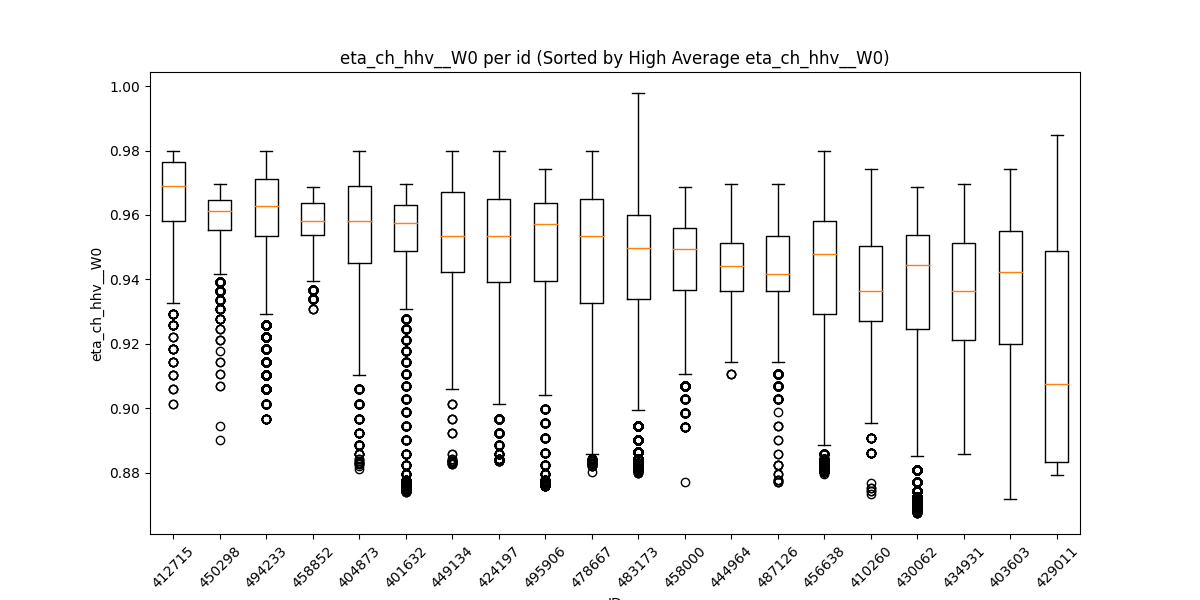

In [78]:
Plot.nfh_property_per_id_boxplot(df_heat_dist, filter_col='batch_import_remeha_boiler_status_burning_ch__bool', property_col='eta_ch_hhv__W0')

## Writing results to multiple zipped CSV files

In [ ]:
# %%time 
# # uncomment this entire block of code to enable it 
# for home_id in tqdm(df_heat_dist.index.get_level_values('id').unique()):
#     df_heat_dist.xs(home_id, drop_level=False).to_csv(
#         f'{home_id}_heat_dist_preprocessed_properties.zip',
#         encoding='utf-8',
#         compression= dict(method='zip',
#                           archive_name=f'{home_id}_heat_dist_preprocessed_properties.csv'),
#         date_format='%Y-%m-%dT%H:%M:%S%z'
#     )
